In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import generic_filter, minimum_filter, median_filter
from IPython.display import Image
from scipy.ndimage import zoom 
from scipy.ndimage.morphology import distance_transform_edt
from matplotlib.tri import Triangulation

from nansat import Nansat, Domain, NSR

from sea_ice_drift import get_n
from sea_ice_drift.lib import get_spatial_mean, get_uint8_image
from sea_ice_drift.ftlib import feature_tracking 
from sea_ice_drift.pmlib import pattern_matching
from sea_ice_drift.pmlib import prepare_first_guess, use_mcc, get_initial_rotation, rotate_and_match

# from s1denoise import Sentinel1Image

from osgeo import gdal
%matplotlib inline

In [2]:
def get_n_radarsat2(filename):
#filename = '/Data/sat/downloads/Radarsat2/beaufort_sea/2013/RS2_OK37499_PK364900_DK322205_SCWA_20130224_023727_HH_HV_SGF'
    # open with nansat to get time
    n01 = Nansat(filename)
    time_coverage_start = n01.time_coverage_start

    # open with Nansat to find HH bandname
    filename_gdal = f'RADARSAT_2_CALIB:UNCALIB:{filename}/product.xml'
    n02 = Nansat(filename_gdal)

    try:
        band_id = n02.get_band_number({'POLARIMETRIC_INTERP': 'HH'})
    except:
        band_id = 1

    # replace zeros in low values (not near border)
    img = n02[band_id]
    img[100:-100, 100:-100] = np.clip(img[100:-100, 100:-100], 1, 255)

    # create new Nansat with one band only
    n03 = Nansat.from_domain(n02, img)
    n03.set_metadata('time_coverage_start', n01.time_coverage_start)
    
    # improve geolocation
    n03.reproject_gcps()
    n03.vrt.tps = True
    return n03


In [3]:
def fill_nan_gaps(array, distance=15):
    """ Fill gaps in input raster

    Parameters
    ----------
    array : 2D numpy.array
        Input ratser with nan values
    distance : int
        Minimum size of gap to fill

    Returns
    -------
    array : 2D numpy.array
        Ratser with nan gaps field with nearest neigbour values

    """
    array = np.array(array)
    dist, indi = distance_transform_edt(
        np.isnan(array),
        return_distances=True,
        return_indices=True)
    gpi = dist <= distance
    r,c = indi[:,gpi]
    array[gpi] = array[r,c]
    return array

In [4]:
def clean_velo_field(a, rpm, hpm, min_qual=2.5, fill_size=1, med_filt_size=3):
    """ Replace gaps with median filtered values """
    a2 = np.array(a)
    a2[(rpm * hpm) < min_qual] = np.nan
    a3 = fill_nan_gaps(a2, fill_size)
    a4 = median_filter(a3, med_filt_size)
    gpi = np.isnan(a2) * np.isfinite(a4) 
    a2[gpi] = a4[gpi]
    return a2

In [5]:
# use original Sentinel-1 SAR files (download from colhub.met.no)
# data_dir = '/Data/sat/downloads/Radarsat2/beaufort_sea/2013'
data_dir = os.getenv('RS2_dir')
f1 = os.path.join(data_dir, 'RS2_OK37499_PK364900_DK322205_SCWA_20130224_023727_HH_HV_SGF')
f2 = os.path.join(data_dir, 'RS2_OK37500_PK364951_DK322250_SCWA_20130225_020811_HH_HV_SGF')

In [6]:
n1 = get_n_radarsat2(f1)
n2 = get_n_radarsat2(f2)

In [7]:
### THIS ONE IS OPTIONAL
### use it to define range of X/Y for intersection of two images
### instead of a fixed range
"""
geo1 = n1.get_border_geometry()
geo2 = n2.get_border_geometry()
inter = geo1.Intersection(geo2)
interlon, interlat = np.array(json.loads(inter.ExportToJson())['coordinates'][0]).T
dom = Domain(NSR(EPSG_CODE).wkt, '-te 0 0 1000 1000 -tr 1 -1')

xbrd, ybrd = dom.transform_points(interlon, interlat, 1)
xmin = np.floor(xbrd.min()/RES)*RES
xmax = np.ceil(xbrd.max()/RES)*RES
ymin = np.floor(ybrd.min()/RES)*RES
ymax = np.ceil(ybrd.max()/RES)*RES
print(xmin, xmax, ymin, ymax)
"""

"\ngeo1 = n1.get_border_geometry()\ngeo2 = n2.get_border_geometry()\ninter = geo1.Intersection(geo2)\ninterlon, interlat = np.array(json.loads(inter.ExportToJson())['coordinates'][0]).T\ndom = Domain(NSR(EPSG_CODE).wkt, '-te 0 0 1000 1000 -tr 1 -1')\n\nxbrd, ybrd = dom.transform_points(interlon, interlat, 1)\nxmin = np.floor(xbrd.min()/RES)*RES\nxmax = np.ceil(xbrd.max()/RES)*RES\nymin = np.floor(ybrd.min()/RES)*RES\nymax = np.ceil(ybrd.max()/RES)*RES\nprint(xmin, xmax, ymin, ymax)\n"

In [8]:
# define regular grid with lon/lat coordinates
EPSG_CODE = 3413
RES = 5000.
xmin, xmax = -1860000, -1330000
ymin, ymax = -60000, 360000
xgrd, ygrd = np.meshgrid(np.arange(xmin, xmax, RES), np.arange(ymax, ymin, -RES))

# destination domain
dst_dom = Domain(NSR(EPSG_CODE).wkt,
        '-te %d %d %d %d -tr %d %d' %
        (xmin, ymin, xmax, ymax, RES, RES))
lon1pm, lat1pm = dst_dom.get_geolocation_grids()
print(lon1pm.shape)
srs=NSR(EPSG_CODE).wkt

(84, 106)


In [9]:
# create fake feature tracking points
n1rows, n1cols = n1.shape()
n2rows, n2cols = n2.shape()

stp = 500
c1, r1 = [a.flatten() for a in np.meshgrid(np.arange(100, n1cols-100, stp), np.arange(100, n1rows-100, stp))]
c1lon, r1lat = n1.transform_points(c1, r1)
c2, r2 = n2.transform_points(c1lon, r1lat, DstToSrc=1)
gpi = (c2 > 0) * (c2 < n2cols) * (r2 > 0) * (r2 < n2rows)
# c2lon, r2lat = n2.transform_points(c2, r2)


97% 10101.5 07660.8 05764.0 07906.0 +00.0 0.44 14.34
 Pattern matching - OK! (685 sec)


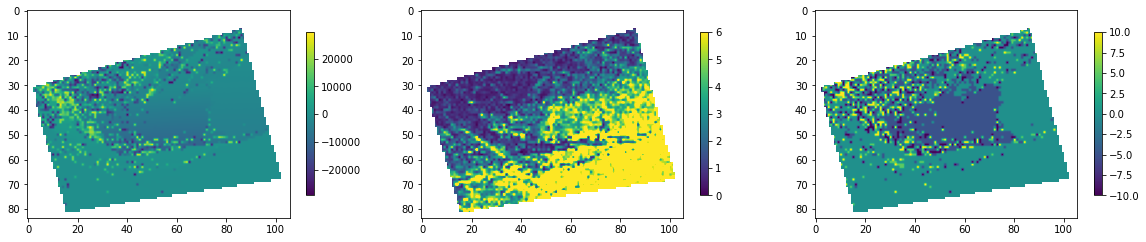

In [10]:
# Run Pattern Matching with excessive parameters
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(
    lon1pm, lat1pm, n1, c1[gpi], r1[gpi], n2, c2[gpi], r2[gpi], 
    srs=srs, img_size=71, 
    min_border=500, max_border=500, 
    angles=[-10, -5, 0, 5, 10],
    threads=10)

fig, ax = plt.subplots(1,3, figsize=(20,10))
im0 = ax[0].imshow(upm)
fig.colorbar(im0, ax=ax[0], shrink=0.3)
im1 = ax[1].imshow(rpm * hpm, clim=[0, 6])
fig.colorbar(im1, ax=ax[1], shrink=0.3)
im2 = ax[2].imshow(apm)
fig.colorbar(im2, ax=ax[2], shrink=0.3)

In [11]:
upm2 = clean_velo_field(upm, rpm, hpm, 2)
vpm2 = clean_velo_field(vpm, rpm, hpm, 2)

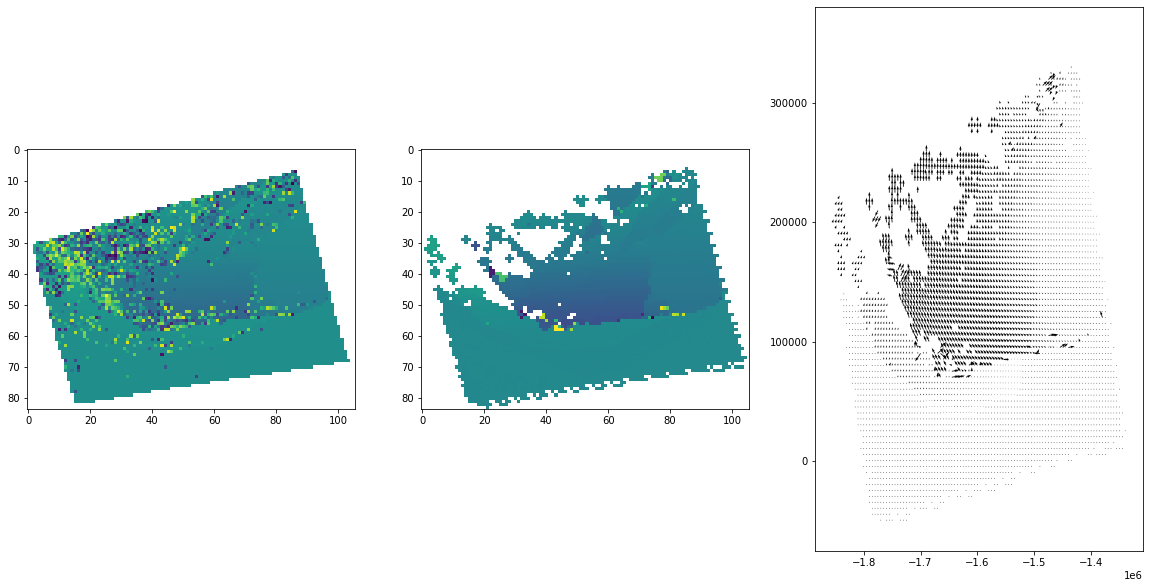

In [12]:
fig, ax = plt.subplots(1,3,figsize=(20,10))
ax[0].imshow(upm)
ax[1].imshow(upm2)
ax[2].quiver(xgrd, ygrd, upm2, vpm2)

In [13]:
def get_deformation_elems(x, y, u, v, a):
    """ Compute deformation for given elements.
    Input X, Y, U, V are organized in three columns: for each node of M elements.
    To convert deformation rates from 1/s to %/day outputs should be multiplied by 8640000.
    Parameters
    ----------
    x : 3xM ndarray
        X-coordinates of nodes, m
    y : 3xM ndarray
        Y-coordinates of nodes, m
    u : 3xM ndarray
        U-component of nodes, m/s
    v : 3xM ndarray
        V-component of nodes, m/s
    a : Mx1 ndarray
        area of elements, m2
    Returns
    -------
    e1 : Mx1 array
        Divergence, 1/s
    e2 : Mx1 array
        Shear, 1/s
    e3 : Mx1 array
        Total deformation, 1/s
    """
    # contour integrals of u and v [m/s * m ==> m2/s]
    ux = uy = vx = vy = 0
    for i0, i1 in zip([1, 2, 0], [0, 1, 2]):
        ux += (u[i0] + u[i1]) * (y[i0] - y[i1])
        uy -= (u[i0] + u[i1]) * (x[i0] - x[i1])
        vx += (v[i0] + v[i1]) * (y[i0] - y[i1])
        vy -= (v[i0] + v[i1]) * (x[i0] - x[i1])
    # divide integral by double area [m2/s / m2 ==> 1/day]
    ux, uy, vx, vy =  [i / (2 * a) for i in (ux, uy, vx, vy)]

    # deformation components
    e1 = ux + vy
    e2 = ((ux - vy) ** 2 + (uy + vx) ** 2) ** 0.5
    e3 = np.hypot(e1, e2)

    return e1, e2, e3

def get_deformation_nodes(x, y, u, v):
    """ Compute deformation for given nodes.
    Input X, Y, U, V are given for individual N nodes. Nodes coordinates are triangulated and
    area, perimeter and deformation is computed for M elements.
    Parameters
    ----------
    x : Nx1 ndarray
        X-coordinates of nodes, m
    y : Nx1 ndarray
        Y-coordinates of nodes, m
    u : Nx1 ndarray
        U-component of nodes, m/s
    v : Nx1 ndarray
        V-component of nodes, m/s
    Returns
    -------
    e1 : Mx1 array
        Divergence, 1/s
    e2 : Mx1 array
        Shear, 1/s
    e3 : Mx1 array
        Total deformation, 1/s
    a : Mx1 array
        Area, m2
    p : Mx1 array
        Perimeter, m
    t : 3xM array
        Triangulation (indices of input nodes for each element)
    """
    tri = Triangulation(x, y)

    # coordinates and speeds of corners of each element
    xt, yt, ut, vt = [i[tri.triangles].T for i in (x, y, u, v)]

    # side lengths (X,Y,tot)
    tri_x = np.diff(np.vstack([xt, xt[0]]), axis=0)
    tri_y = np.diff(np.vstack([yt, yt[0]]), axis=0)
    tri_s = np.hypot(tri_x, tri_y)
    # perimeter
    tri_p = np.sum(tri_s, axis=0)
    s = tri_p/2
    # area
    tri_a = np.sqrt(s * (s - tri_s[0]) * (s - tri_s[1]) * (s - tri_s[2]))

    # deformation components
    e1, e2, e3 = get_deformation_elems(xt, yt, ut, vt, tri_a)

    return e1, e2, e3, tri_a, tri_p, tri.triangles

In [14]:
gpi = np.isfinite(upm2*vpm2)
e1, e2, e3, a, p, t = get_deformation_nodes(xgrd[gpi], ygrd[gpi], upm2[gpi], vpm2[gpi])

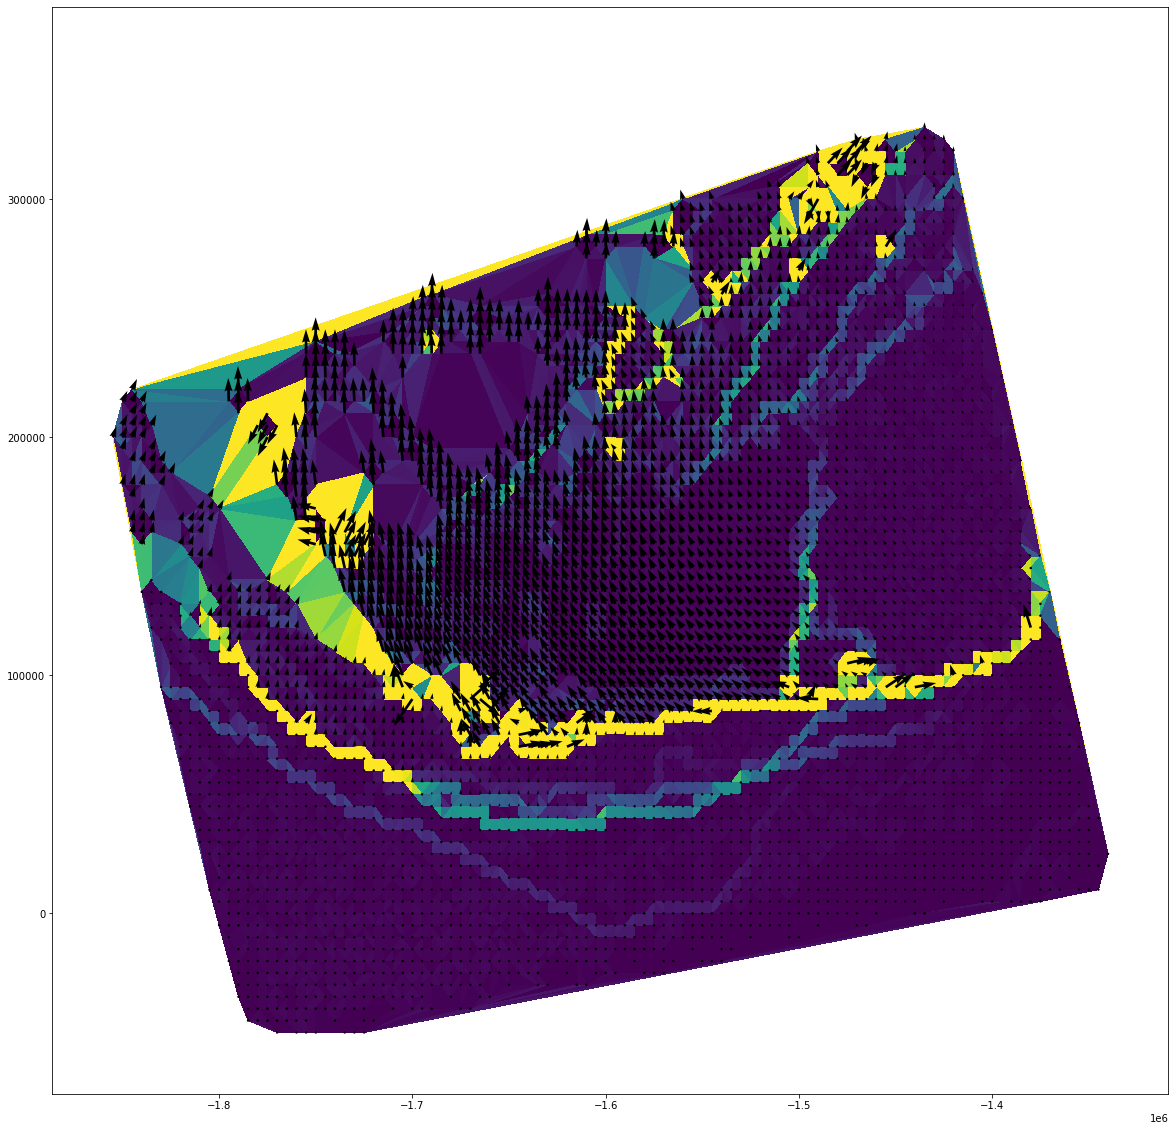

In [15]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
ax.tripcolor(xgrd[gpi], ygrd[gpi], t, e2, mask=np.isnan(e2), vmax=1)
ax.quiver(xgrd, ygrd, upm2, vpm2)